# Pegasus data analysis

Jörn's analysis of the Pegasus data. 

## Reading and cleaning

We start by reading the data from disk.

In [37]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
%precision 2
pd.options.display.float_format = '{:,.2f}'.format

# read raw csv file
ordersFile = "D:\\Universitaet\\Lehrstuhl Koeln Grahl\\02 Forschung\\Aktiv\\Pegasus\\data\\orders.txt"
data = pd.read_csv(ordersFile, sep="\t", parse_dates=['dateOfOrder']) # read file
# compute order value
data['orderValue'] = data['price'] * data['amount'] # compute order value 

data[:5] # verify by showing top 5 lines

,id,dateOfOrder,customerId,typeOfOrder,id.1,orderId,articleId,title,amount,price,discount,orderValue
0,190,2004-05-11 16:47:01,29957,ORDER,743.00,190.00,HER00500,Fantasy Hero,1.00,38.40,nan,38.40
1,191,2004-05-11 16:51:35,30247,ORDER,744.00,191.00,FFG0WC01,Warcraft DEUTSCH,1.00,39.95,nan,39.95
2,191,2004-05-11 16:51:35,30247,ORDER,745.00,191.00,EAG00004,Civilization DEUTSCH,1.00,49.99,nan,49.99
3,192,2004-05-11 17:29:35,29895,ORDER,746.00,192.00,GSG0F132,Unter Druck,1.00,10.10,nan,10.10
4,192,2004-05-11 17:29:35,29895,ORDER,747.00,192.00,GIV02030,Konzernreport #2: Lazarus,1.00,9.50,nan,9.50


In [2]:
data.describe()

,id,customerId,id.1,orderId,amount,price,discount,orderValue
count,"1,454,437.00","1,454,437.00","1,454,433.00","1,454,433.00","1,454,433.00","1,394,006.00",23.00,"1,394,006.00"
mean,"149,861.58","14,642.62","728,021.01","149,861.90",2.41,12.46,24.78,31.64
std,"89,050.63","7,992.95","419,897.83","89,050.53",89.82,14.22,1.04,430.40
min,190.00,-1.00,743.00,190.00,"-36,138.00",-1.00,20.00,-12.00
25%,"70,150.00","11,239.00","364,379.00","70,151.00",1.00,4.77,25.00,6.49
50%,"149,593.00","12,061.00","728,033.00","149,594.00",1.00,8.24,25.00,12.97
75%,"229,428.00","13,477.00","1,091,641.00","229,428.00",2.00,15.99,25.00,24.00
max,"296,838.00","108,272.00","1,455,320.00","296,838.00","90,910.00","1,532.86",25.00,"221,848.00"


Strange things: 
1. Discounts only available for 23 observations
1. Negative prices
1. These vars have fewer values than total number of obs: `orderId`, `amount`, `price`
1. Negative customer Id
1. Max `order value` is huge!
1. Max `amount` is huge, min `amount` is negative!

What I do first: 
1. I drop `discount` var. 
1. I remove all obs with `prices<0`.
1. I drop all obs that have missing values.
1. I keep only customers with a `customerId > 0`

In [3]:
data = data.drop(['discount'], axis = 1) # drop discount column
data.dropna(inplace = True) # remove rows that have a missing value
data = data.loc[data['price'] >= 0] # remove orders with negative prices
data = data.loc[data['customerId'] > 0] # remove negative customer IDs
data.describe() # once more

,id,customerId,id.1,orderId,amount,price,orderValue
count,"1,384,879.00","1,384,879.00","1,384,879.00","1,384,879.00","1,384,879.00","1,384,879.00","1,384,879.00"
mean,"149,394.76","14,685.68","725,758.67","149,394.76",2.51,12.42,31.71
std,"88,569.98","7,780.82","417,416.32","88,569.98",10.24,14.16,431.81
min,190.00,"10,000.00",743.00,190.00,1.00,0.00,0.00
25%,"70,261.00","11,256.00","364,897.50","70,261.00",1.00,4.75,6.47
50%,"148,753.00","12,061.00","725,065.00","148,753.00",1.00,8.22,12.95
75%,"227,849.00","13,469.00","1,083,495.50","227,849.00",2.00,15.93,24.00
max,"296,838.00","108,272.00","1,455,320.00","296,838.00","3,000.00","1,532.86","221,848.00"


Count is identical for all vars. Prices >= 0. Discounts removed.

In [4]:
pd.unique(data['typeOfOrder']) # there are several possible entries for the order column
data = data.loc[data['typeOfOrder'] == "ORDER"] # keep rows that are ORDERS
data.describe()

,id,customerId,id.1,orderId,amount,price,orderValue
count,"1,384,704.00","1,384,704.00","1,384,704.00","1,384,704.00","1,384,704.00","1,384,704.00","1,384,704.00"
mean,"149,399.87","14,683.32","725,781.68","149,399.87",2.51,12.42,31.72
std,"88,573.15","7,778.30","417,432.45","88,573.15",10.24,14.16,431.84
min,190.00,"10,000.00",743.00,190.00,1.00,0.00,0.00
25%,"70,256.00","11,256.00","364,853.75","70,256.00",1.00,4.75,6.47
50%,"148,763.00","12,061.00","725,120.50","148,763.00",1.00,8.22,12.95
75%,"227,858.00","13,469.00","1,083,541.25","227,858.00",2.00,15.93,24.00
max,"296,838.00","108,272.00","1,455,320.00","296,838.00","3,000.00","1,532.86","221,848.00"


Now I look at order value. What is going on with the large orders?

In [5]:
data[['orderValue', 'amount']].describe(percentiles = [.25, .5, .75, .9, .99, .999]) # show descriptive stats

,orderValue,amount
count,"1,384,704.00","1,384,704.00"
mean,31.72,2.51
std,431.84,10.24
min,0.00,1.00
25%,6.47,1.00
50%,12.95,1.00
75%,24.00,2.00
90%,49.32,4.00
99%,274.75,20.00
99.9%,"1,562.88",90.00


I decide (for now) to remove the top 1% orders (`orderValue <= 274.75` and `amount <= 20`)

In [6]:
data = data.loc[(data['amount'] <= 20) & (data['orderValue'] <= 274.75)] # keep the 99%
data.describe()

,id,customerId,id.1,orderId,amount,price,orderValue
count,"1,364,274.00","1,364,274.00","1,364,274.00","1,364,274.00","1,364,274.00","1,364,274.00","1,364,274.00"
mean,"148,837.02","14,695.02","723,233.94","148,837.02",2.04,12.05,20.83
std,"88,669.23","7,818.13","417,930.75","88,669.23",2.26,12.79,27.27
min,190.00,"10,000.00",743.00,190.00,1.00,0.00,0.00
25%,"69,689.00","11,246.00","361,861.25","69,689.00",1.00,4.73,6.37
50%,"147,045.00","12,061.00","719,117.50","147,045.00",1.00,8.22,12.85
75%,"227,487.00","13,465.00","1,081,538.75","227,487.00",2.00,15.73,23.02
max,"296,838.00","108,272.00","1,455,320.00","296,838.00",20.00,270.41,274.74


This is all for now.  
I now compute descriptives for this cleaned dataset. 

## About customers and orders



In [7]:
customerIds = pd.unique(data['customerId']) # get all customerIds
numberOfCustomers = len(customerIds) # count
numberOfOrders = data.shape[0] # get number of rows of order dataset

The number of customers: 

In [8]:
numberOfCustomers

17353

The number of 
orders:

In [9]:
numberOfOrders

1364274

I now aggregate data on customer level in order to describe customer behavior.  
I compute order value as `amount x price`.

In [10]:
# group by customer and compute some statistics
d = data.groupby('customerId')['orderValue'].agg(['sum', 'count']).describe()

The average number of orders placed by customers:

In [11]:
d['count']['mean'] # avg number of orders

78.62

The average total money spent by a customers:

In [12]:
d['sum']['mean'] # total EUR spent, on avg

1637.65

Let's take a look at the order values:

Text(0.5,1,'Histogram - order value')

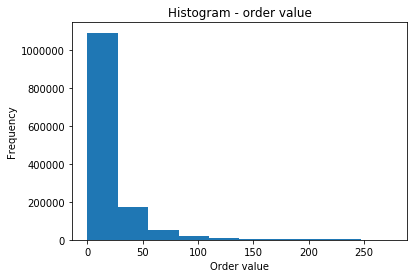

In [13]:
# plot a histogram for order values
plt.hist(data['orderValue'])
plt.xlabel("Order value") 
plt.ylabel("Frequency")
plt.title("Histogram - order value")

In [14]:
data['orderValue'].describe(percentiles = [.25, .5, .75, .9, .99])

count   1,364,274.00
mean           20.83
std            27.27
min             0.00
25%             6.37
50%            12.85
75%            23.02
90%            44.07
99%           147.20
max           274.74
Name: orderValue, dtype: float64

## About products

The number of products:

In [15]:
productIds = pd.unique(data['articleId']) # get all productIds
numberOfProducts = len(productIds) # count
numberOfProducts

38045

What is the distribution of product prices?

In [16]:
d = data.groupby('articleId')['price'].agg(['mean'])
d.describe(percentiles = [.25, .5, .75, .99])

,mean
count,"38,045.00"
mean,12.41
std,15.24
min,0.00
25%,4.60
50%,8.15
75%,14.74
99%,74.75
max,270.41


Text(0.5,1,'Histogram - price')

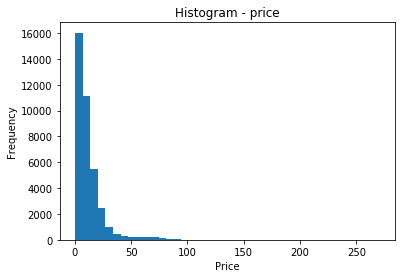

In [17]:
# plot a histogram for prices
plt.hist(d['mean'], bins = 40)
plt.xlabel("Price") 
plt.ylabel("Frequency")
plt.title("Histogram - price")

What are the bestselling products?

In [18]:
productCounts = data['title'].value_counts()
productCounts[:20] # show the top 20

Munchkin Kartenspiel              7462
Munchkin 2: Abartige Axt          5021
Munchkin 3: Beschwörungsfehler    4666
Munchkin 4: Rasende Rösser        4055
Munchkin 1+2                      3226
Munchkin 5: Wirre Waldläufer      3162
Smash Up                          2562
Munchkin 6: Durchge. Dungeons     2370
Shadowrun Regelbuch, 5.Ed.(HC)    2249
Port Royal                        2152
Chez Geek: Das WG-Kartenspiel     1973
Ultimate Guard Kartenbox Card     1960
Shadowrun Regelbuch, 5. Editio    1959
Junta                             1949
Munchkin Zombies                  1924
Munchkin Quest: Das Brettspiel    1880
Munchkin Zombies 1+2              1716
Shadowrun Regelbuch (HC)          1706
Zombies!!! 2: Zombie-Korps        1603
Camel Up *SdJ 2014*               1600
Name: title, dtype: int64

Draw a Lorenz curve, consider units sold. 

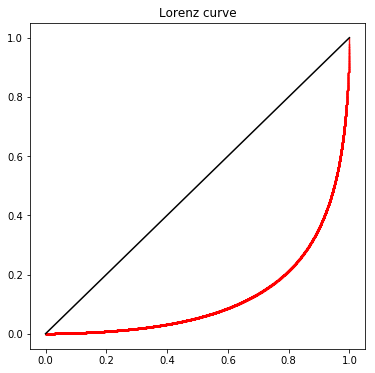

In [72]:
def lorenzCurve(X): # simple lorenz curve from https://zhiyzuo.github.io/Plot-Lorenz/
    plt.clf()
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0) 
    X_lorenz[0], X_lorenz[-1]
    fig, ax = plt.subplots(figsize=[6,6])
    ## scatter plot of Lorenz curve
    ax.scatter(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, 
               marker='.', color='red', s=1)
    ## line plot of equality
    plt.title("Lorenz curve")
    ax.plot([0,1], [0,1], color='k')
    
temp = data['title'].value_counts(ascending = True).values
lorenzCurve(temp)

How much money do the products contribute?

In [58]:
totalSales = data['orderValue'].sum() # total money in dataset
salesByProduct = data.groupby('title')['orderValue'].agg(['sum']) # sum sales of each product
salesByProduct['salesShare'] = salesByProduct['sum'] / totalSales *100. # compute ratio 
salesByProduct.sort_values(by='sum', ascending = False)[:20] # show the top 20

,sum,salesShare
title,,
MAGIC: THE GATHERING Eternal M,"1,123,554.36",2.55
Modern Masters 2015 Booster DP,"1,112,295.45",2.52
Modern Masters Booster DP,"654,394.53",1.48
Khans of Tarkir Booster DP,"398,095.08",0.90
Return to Ravnica Booster DP,"386,050.14",0.88
Battle for Zendikar Booster DP,"361,678.22",0.82
MAGIC: THE GATHERING Kaladesh,"300,708.85",0.68
MAGIC: THE GATHERING Shadows o,"280,702.47",0.64
Theros Booster DP,"279,767.93",0.63


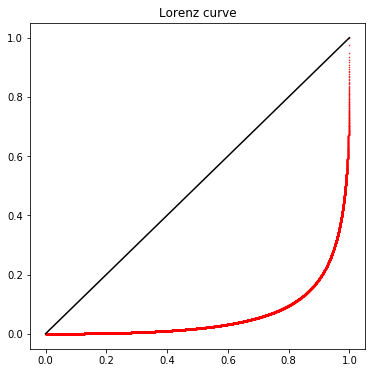

In [73]:
temp = salesByProduct['salesShare'].sort_values(ascending = True)
temp.dropna(inplace = True) # remove rows that have a missing value
lorenzCurve(temp.values)